<a href="https://colab.research.google.com/github/matteomrz/20242R0136COSE47402/blob/main/final/final_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Hide Output with %%capture
%%capture
!pip install openai-clip
!pip install datasets
!pip install torch
!pip install tqdm

In [3]:
from datasets import load_dataset
from torch.utils.data import random_split

ds = load_dataset("bazyl/GTSRB")

train = ds['train']
test = ds['test']

base_label = 'a picture of a '
end_label = ' street sign'

id_to_description = {
    18: "General caution",
    19: "Dangerous curve left",
    20: "Dangerous curve right",
    21: "Winding road",
    22: "Bumpy road",
    23: "Slippery road",
    24: "Road narrows on the right",
    25: "Road work",
    26: "Traffic lights",
    27: "Pedestrians",
    28: "Children crossing",
    29: "Bike crossing",
    30: "Beware of ice/snow",
    31: "Wild animals crossing",
}

train = [example for example in train if example['ClassId'] in id_to_description]
test = [example for example in test if example['ClassId'] in id_to_description]

for instance in train:
    instance['Description'] = base_label + id_to_description[instance['ClassId']] + end_label

len_train = int(0.8 * len(train))
train, val = random_split(train, [len_train, len(train) - len_train])

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/4.83k [00:00<?, ?B/s]

dataset_infos.json:   0%|          | 0.00/3.46k [00:00<?, ?B/s]

(…)-00000-of-00001-dc762c064c221993.parquet:   0%|          | 0.00/236M [00:00<?, ?B/s]

(…)-00000-of-00001-747a54d4a6461a97.parquet:   0%|          | 0.00/76.2M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/39209 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/12630 [00:00<?, ? examples/s]

In [4]:
import clip
import torch
import matplotlib.pyplot as plt
from io import BytesIO
from PIL import Image
from torch.utils.data import Dataset
import torch.nn as nn

In [5]:
class WarningSignDataset(Dataset):
  def __init__(self, data, is_test = False):
    self.data = data
    self.is_test = is_test

  def __len__(self):
    return len(self.data)

  def __getitem__(self, idx):
    item = self.data[idx]
    image = Image.open(BytesIO(item['Path']['bytes']))
    text = item['Description'] if not self.is_test else ''
    class_id = item['ClassId'] - min(id_to_description.keys())
    return preprocess(image), text, class_id

In [6]:
from torch.utils.data import DataLoader
import torch.optim as optim
from torch import nn

device = "cuda:0" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32",device=device,jit=False)

# Data Loaders for Train, Val and Test
train_dataloader = DataLoader(WarningSignDataset(train),batch_size = 32, shuffle=True)
val_dataloader = DataLoader(WarningSignDataset(val),batch_size = 32, shuffle=False)
test_dataloader = DataLoader(WarningSignDataset(test, is_test=True),batch_size = 32, shuffle=False)

100%|███████████████████████████████████████| 338M/338M [00:03<00:00, 91.6MiB/s]


In [7]:
# Baseline Quantitative Results: CLIP Zero-Shot Prediction
all_classes = torch.cat([clip.tokenize(base_label + description + end_label) for description in id_to_description.values()])

model.eval()
total = 0
correct = 0
with torch.no_grad():
  for images, _, classId in test_dataloader:
    images= images.to(device)
    texts = all_classes.to(device)
    logits_per_image, logits_per_text = model(images, texts)
    pred = torch.argmax(logits_per_image, dim=-1).cpu().numpy()
    total += len(images)
    correct += (classId == pred).sum().item()

print(f"Zero Shot Accuracy: {100*correct/total}%")

Zero Shot Accuracy: 21.68776371308017%


<ipython-input-35-5ac33c70d313>:20: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  axes[int(i/2)][i%2].set_title(f"Predicted: {id_to_description[int(pred) + min(id_to_description.keys())]}, \


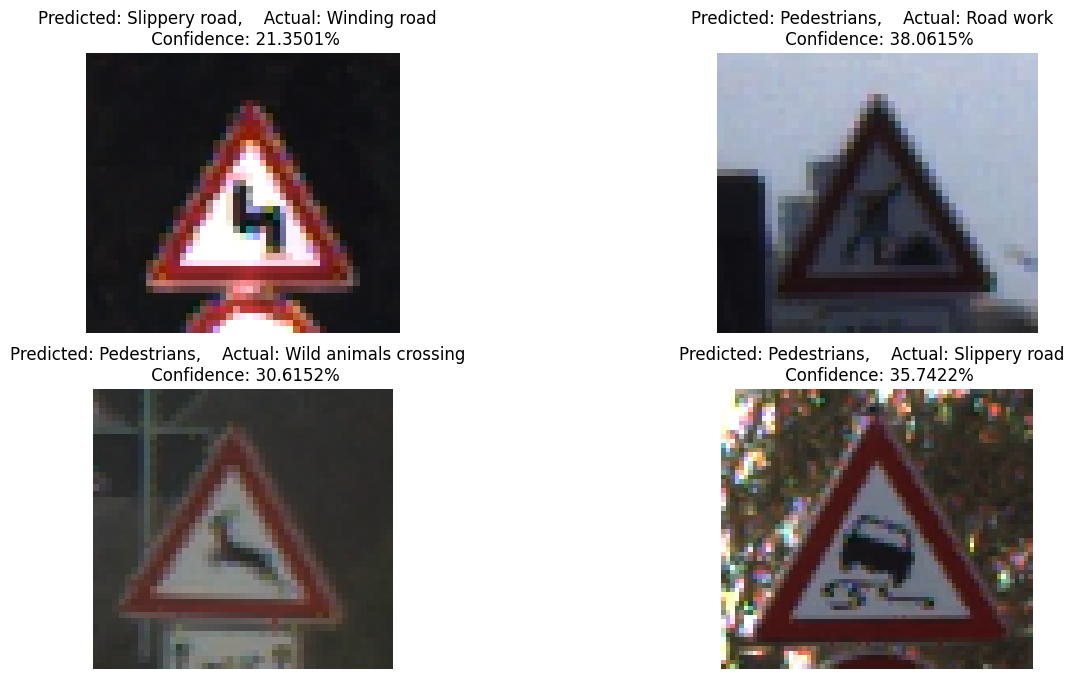

In [35]:
# Baseline Qualitative Results: CLIP Zero-Shot Prediction
idx = [20, 38, 102, 387]

fig, axes = plt.subplots(2, 2, figsize=(15, 8))

model.eval()
for i, index in enumerate(idx):
  data_entry = test[index]
  image = Image.open(BytesIO(data_entry['Path']['bytes']))
  image_input = preprocess(image).unsqueeze(0).to(device)
  texts = all_classes.to(device)

  with torch.no_grad():
    logits_per_image, logits_per_text = model(image_input, texts)

  prob = logits_per_image.softmax(dim=-1).cpu().numpy()
  pred = logits_per_image.argmax(dim=-1).cpu().numpy()

  axes[int(i/2)][i%2].imshow(image)
  axes[int(i/2)][i%2].set_title(f"Predicted: {id_to_description[int(pred) + min(id_to_description.keys())]}, \
   Actual: {id_to_description[int(data_entry['ClassId'])]}  \n Confidence: {100*prob[0][pred][0]:.4f}%")
  axes[int(i/2)][i%2].axis('off')

In [70]:
from tqdm import tqdm

# code for training pipeline and clip initialization from
# https://github.com/openai/CLIP/issues/83#issue-853114174

# without this the loss is NaN
# https://github.com/openai/CLIP/issues/57
def convert_models_to_fp32(model):
  for p in model.parameters():
    p.data = p.data.float()
    p.grad.data = p.grad.data.float()

loss_img = nn.CrossEntropyLoss()
loss_txt = nn.CrossEntropyLoss()

# Try out different optimizers
optimizer = optim.AdamW(model.parameters(), lr=1e-5)
# SGD showed no promising results
# optimizer = torch.optim.SGD(model.parameters(), lr=1e-3, momentum=0.9, weight_decay=8e-5)

# Model reaches 99%+ accuracy after one iteration,
# so big epoch_num not required
epoch_num = 3

for epoch in range(epoch_num):

  # TRAINING
  model.train()
  running_loss = 0.0
  pbar = tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{epoch_num}, Loss: 0.0000")
  for images, texts, _ in pbar :
    optimizer.zero_grad()

    images= images.to(device)
    texts = clip.tokenize(texts).to(device)

    logits_per_image, logits_per_text = model(images, texts)

    ground_truth = torch.arange(len(images),dtype=torch.long,device=device)

    total_loss = (loss_img(logits_per_image,ground_truth) + loss_txt(logits_per_text,ground_truth))/2
    total_loss.backward()
    running_loss += total_loss.item()

    # Fixes NaN loss
    if device == "cpu":
      optimizer.step()
    else :
      convert_models_to_fp32(model)
      optimizer.step()
      clip.model.convert_weights(model)

    pbar.set_description(f"Epoch {epoch+1}/{epoch_num}, Loss: {running_loss/len(train_dataloader):.4f}")

  print(f"Epoch {epoch+1}/{epoch_num}, Loss: {running_loss/len(train_dataloader):.4f}")

  # VALIDATION
  model.eval()
  total = 0
  correct = 0
  with torch.no_grad():
    for images, texts, classId in val_dataloader:
      images= images.to(device)
      texts = clip.tokenize(texts).to(device)
      image_features = model.encode_image(images)
      text_features = model.encode_text(texts)
      logits_per_image, logits_per_text = model(images, texts)
      pred = torch.argmax(logits_per_image, dim=-1).cpu().numpy()
      total += len(images)

      # prediction uses first text in the batch that fits the image the most,
      # so check if classid of the predicted text is right
      for i in range(len(images)):
        if classId[i] == classId[pred[i]]:
          correct += 1

  print(f"Validation Accuracy: {100*correct/total}%")

# save model
torch.save(model.state_dict(), 'clip_finetuned.pth')

Epoch 1/3, Loss: 1.4175: 100%|██████████| 192/192 [00:45<00:00,  4.24it/s]


Epoch 1/3, Loss: 1.4175
Validation Accuracy: 99.34640522875817%


Epoch 2/3, Loss: 1.2549: 100%|██████████| 192/192 [00:45<00:00,  4.23it/s]


Epoch 2/3, Loss: 1.2549
Validation Accuracy: 99.73856209150327%


Epoch 3/3, Loss: 1.2403: 100%|██████████| 192/192 [00:44<00:00,  4.30it/s]


Epoch 3/3, Loss: 1.2403
Validation Accuracy: 99.80392156862744%


In [85]:
# TESTING
model.eval()
total = 0
correct = 0
with torch.no_grad():
  for images, _, classId in test_dataloader:
    images= images.to(device)
    texts = all_classes.to(device)
    logits_per_image, logits_per_text = model(images, texts)
    pred = torch.argmax(logits_per_image, dim=-1).cpu().numpy()
    total += len(images)
    correct += (classId == pred).sum().item()

print(f"Test Accuracy: {100*correct/total}%")

Test Accuracy: 21.68776371308017%
